In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import warnings

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore') 

data = datasets.load_wine()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [3]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [5]:
df.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [6]:
df['target'].value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

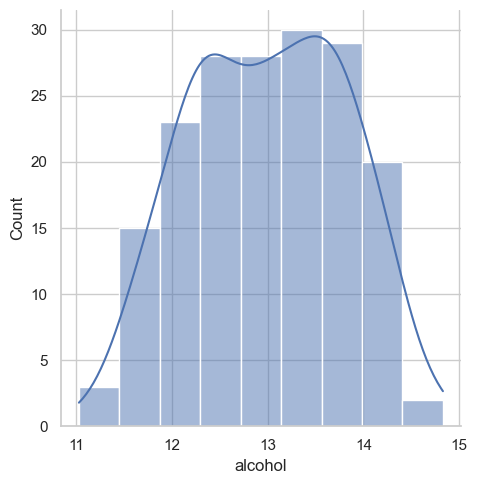

In [7]:
sns.displot(data=df, x="alcohol", kde=True)

### Преобразование данных
#### Разделение на обучающую и тестовые наборв

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Масштабирование

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

#### Подбор наилучшего подмножетсва признаков (RFECV)

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV

rfecv = RFECV(estimator=RidgeClassifierCV())
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal numbers of feature: {rfecv.n_features_}")
features = list(X_train_scaled.columns[rfecv.support_])
print(f"Selected features: {features}")

Optimal numbers of feature: 9
Selected features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'flavanoids', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [11]:
X_train_scaled = X_train_scaled[features]
X_test_scaled = X_test_scaled[features]

### Подбор гиперпараметров

In [12]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5, shuffle=True, random_state=19)

KNN

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

neighbors_grid = [3,5,7,9,11]
params_knn = [{"n_neighbors": neighbors_grid}]

searcher_knn = GridSearchCV(KNeighborsClassifier(), params_knn, cv=cv, scoring="roc_auc_ovr", error_score="raise")
searcher_knn.fit(X_train_scaled, y_train)

optimal_n_neighbors_knn = searcher_knn.best_params_["n_neighbors"]
print(f"Neighbors: {optimal_n_neighbors_knn}")

Neighbors: 11


SVM

In [14]:
from sklearn.svm import SVC

kernel_grid = ["linear", "rbf"]
c_svm_grid = [0.1, 0.25, 0.5, 0.75, 1]
gamma_grid = ["scale", "auto"]
params_svm = [{"kernel": kernel_grid, 
               "C": c_svm_grid, 
               "gamma": gamma_grid}]

searcher_svm = GridSearchCV(SVC(random_state=19, probability=True), params_svm, cv=cv, scoring="roc_auc_ovr", error_score="raise")
searcher_svm.fit(X_train_scaled, y_train)

optimal_kernel = searcher_svm.best_params_["kernel"]
print(f"Kernel: {optimal_kernel}")
optimal_c_svm = searcher_svm.best_params_["C"]
print(f"C: {optimal_c_svm}")
optimal_gamma = searcher_svm.best_params_["gamma"]
print(f"Gamma: {optimal_gamma}")

Kernel: linear
C: 1
Gamma: scale


Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

c_lg_grid = np.arange(1e-05, 5, 1)
params_lg = [{"C" : c_lg_grid}]

searcher_lg = GridSearchCV(LogisticRegression(), params_lg, cv=cv, scoring="roc_auc_ovr", error_score="raise")
searcher_lg.fit(X_train_scaled, y_train)

optimal_c_lg = searcher_lg.best_params_["C"]
print(f"C: {optimal_c_lg}")

C: 4.00001


Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB

var_smoothing_grid = np.logspace(0, -9)
params_nb = [{"var_smoothing" : var_smoothing_grid}]

sercher_nb = GridSearchCV(GaussianNB(), params_nb, cv=cv, scoring="roc_auc_ovr", error_score="raise")
sercher_nb.fit(X_train_scaled, y_train)

optimal_var_smoothing = sercher_nb.best_params_["var_smoothing"]
print(f"var_smoothing: {optimal_var_smoothing}")

var_smoothing: 0.07906043210907697


Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier

max_depth_grid = range(1, 11)
min_samples_leaf_grid = [2, 4, 6]
min_samples_split_grid = [2, 6, 6]
params_dt = [{"max_depth": max_depth_grid,
              "min_samples_leaf": min_samples_leaf_grid,
              "min_samples_split": min_samples_split_grid}]

searcher_dt = GridSearchCV(DecisionTreeClassifier(random_state=19), params_dt, cv=cv, scoring="roc_auc_ovr", error_score="raise")
searcher_dt.fit(X_train_scaled, y_train)

optimal_max_depth = searcher_dt.best_params_["max_depth"]
print(f"Max depth: {optimal_max_depth}")
optimal_min_samples_leaf = searcher_dt.best_params_["min_samples_leaf"]
print(f"Min samples leaf: {optimal_min_samples_leaf}")
optimal_min_samples_split = searcher_dt.best_params_["min_samples_split"]
print(f"Min samples split: {optimal_min_samples_split}")

Max depth: 3
Min samples leaf: 6
Min samples split: 2


### Обучение и тестирование моделей

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

accuracies = {}
times = {}

def time_model(model, X, y):
    t = cross_validate(model, X, y, cv=5)["fit_time"].mean()
    return t

In [19]:
knn = KNeighborsClassifier(optimal_n_neighbors_knn)
svm = SVC(kernel=optimal_kernel, C=optimal_c_svm, gamma=optimal_gamma, random_state=19)
lg = LogisticRegression(C=optimal_c_lg)
nb = GaussianNB(var_smoothing=optimal_var_smoothing)
dt = DecisionTreeClassifier(max_depth=optimal_max_depth, min_samples_leaf=optimal_min_samples_leaf, min_samples_split=optimal_min_samples_split, random_state=19)

#### Стратегия OneVsRest

In [20]:
from sklearn.multiclass import OneVsRestClassifier

KNN

In [21]:
knn_ovr = OneVsRestClassifier(knn).fit(X_train_scaled, y_train)
y_knn_ovr = knn_ovr.predict(X_test_scaled)

accuracies["knn_ovr"] = accuracy_score(y_test, y_knn_ovr)
times["knn_ovr"] = time_model(knn_ovr, X_train_scaled, y_train)

SVM

In [22]:
svm_ovr = OneVsRestClassifier(svm).fit(X_train_scaled, y_train)
y_svm_ovr = svm_ovr.predict(X_test_scaled)

accuracies["svm_ovr"] = accuracy_score(y_test, y_svm_ovr)
times["svm_ovr"] = time_model(svm_ovr, X_train_scaled, y_train)

Logistic Regression

In [23]:
lg_ovr = OneVsRestClassifier(lg).fit(X_train_scaled, y_train)
y_lg_ovr = lg_ovr.predict(X_test_scaled)

accuracies["lg_ovr"] = accuracy_score(y_test, y_lg_ovr)
times["lg_ovr"] = time_model(lg_ovr, X_train_scaled, y_train)

Naive Bayes

In [24]:
nb_ovr = OneVsRestClassifier(nb).fit(X_train_scaled, y_train)
y_nb_ovr = nb_ovr.predict(X_test_scaled)

accuracies["nb_ovr"] = accuracy_score(y_test, y_nb_ovr)
times["nb_ovr"] = time_model(nb_ovr, X_train_scaled, y_train)

Decision Tree

In [25]:
dt_ovr = OneVsRestClassifier(dt).fit(X_train_scaled, y_train)
y_dt_ovr = dt_ovr.predict(X_test_scaled)

accuracies["dt_ovr"] = accuracy_score(y_test, y_dt_ovr)
times["dt_ovr"] = time_model(dt_ovr, X_train_scaled, y_train)

#### Стратегия OneVsOne

In [26]:
from sklearn.multiclass import OneVsOneClassifier

KNN

In [27]:
knn_ovo = OneVsOneClassifier(knn).fit(X_train_scaled, y_train)
y_knn_ovo = knn_ovo.predict(X_test_scaled)

accuracies["knn_ovo"] = accuracy_score(y_test, y_knn_ovo)
times["knn_ovo"] = time_model(knn_ovo, X_train_scaled, y_train)

SVM

In [28]:
svm_ovo = OneVsOneClassifier(svm).fit(X_train_scaled, y_train)
y_svm_ovo = svm_ovo.predict(X_test_scaled)

accuracies["svm_ovo"] = accuracy_score(y_test, y_svm_ovo)
times["svm_ovo"] = time_model(svm_ovo, X_train_scaled, y_train)

LG

In [29]:
lg_ovo = OneVsOneClassifier(lg).fit(X_train_scaled, y_train)
y_lg_ovo = lg_ovo.predict(X_test_scaled)

accuracies["lg_ovo"] = accuracy_score(y_test, y_lg_ovo)
times["lg_ovo"] = time_model(lg_ovo, X_train_scaled, y_train)

NB

In [30]:
nb_ovo = OneVsOneClassifier(nb).fit(X_train_scaled, y_train)
y_nb_ovo = nb_ovo.predict(X_test_scaled)

accuracies["nb_ovo"] = accuracy_score(y_test, y_nb_ovo)
times["nb_ovo"] = time_model(nb_ovo, X_train_scaled, y_train)

DT

In [31]:
dt_ovo = OneVsRestClassifier(dt).fit(X_train_scaled, y_train)
y_dt_ovo = dt_ovo.predict(X_test_scaled)

accuracies["dt_ovo"] = accuracy_score(y_test, y_dt_ovo)
times["dt_ovo"] = time_model(dt_ovo, X_train_scaled, y_train)

#### Стратегия OutputCode

In [32]:
from sklearn.multiclass import OutputCodeClassifier

KNN

In [33]:
knn_oc = OutputCodeClassifier(knn).fit(X_train_scaled, y_train)
y_knn_oc = knn_oc.predict(X_test_scaled)

accuracies["knn_oc"] = accuracy_score(y_test, y_knn_oc)
times["knn_oc"] = time_model(knn_oc, X_train_scaled, y_train)

SVM

In [34]:
svm_oc = OutputCodeClassifier(svm).fit(X_train_scaled, y_train)
y_svm_oc = svm_oc.predict(X_test_scaled)

accuracies["svm_oc"] = accuracy_score(y_test, y_svm_oc)
times["svm_oc"] = time_model(svm_oc, X_train_scaled, y_train)

LG

In [35]:
lg_oc = OutputCodeClassifier(lg).fit(X_train_scaled, y_train)
y_lg_oc = lg_oc.predict(X_test_scaled)

accuracies["lg_oc"] = accuracy_score(y_test, y_lg_oc)
times["lg_oc"] = time_model(lg_oc, X_train_scaled, y_train)

NB

In [36]:
nb_oc = OneVsRestClassifier(nb).fit(X_train_scaled, y_train)
y_nb_oc = nb_oc.predict(X_test_scaled)

accuracies["nb_oc"] = accuracy_score(y_test, y_nb_oc)
times["nb_oc"] = time_model(nb_oc, X_train_scaled, y_train)

DT

In [37]:
dt_oc = OneVsRestClassifier(dt).fit(X_train_scaled, y_train)
y_dt_oc = dt_oc.predict(X_test_scaled)

accuracies["dt_oc"] = accuracy_score(y_test, y_dt_oc)
times["dt_oc"] = time_model(dt_oc, X_train_scaled, y_train)

### Сравнение моделей
#### Точность

<AxesSubplot: xlabel='algorithms', ylabel='accuracy'>

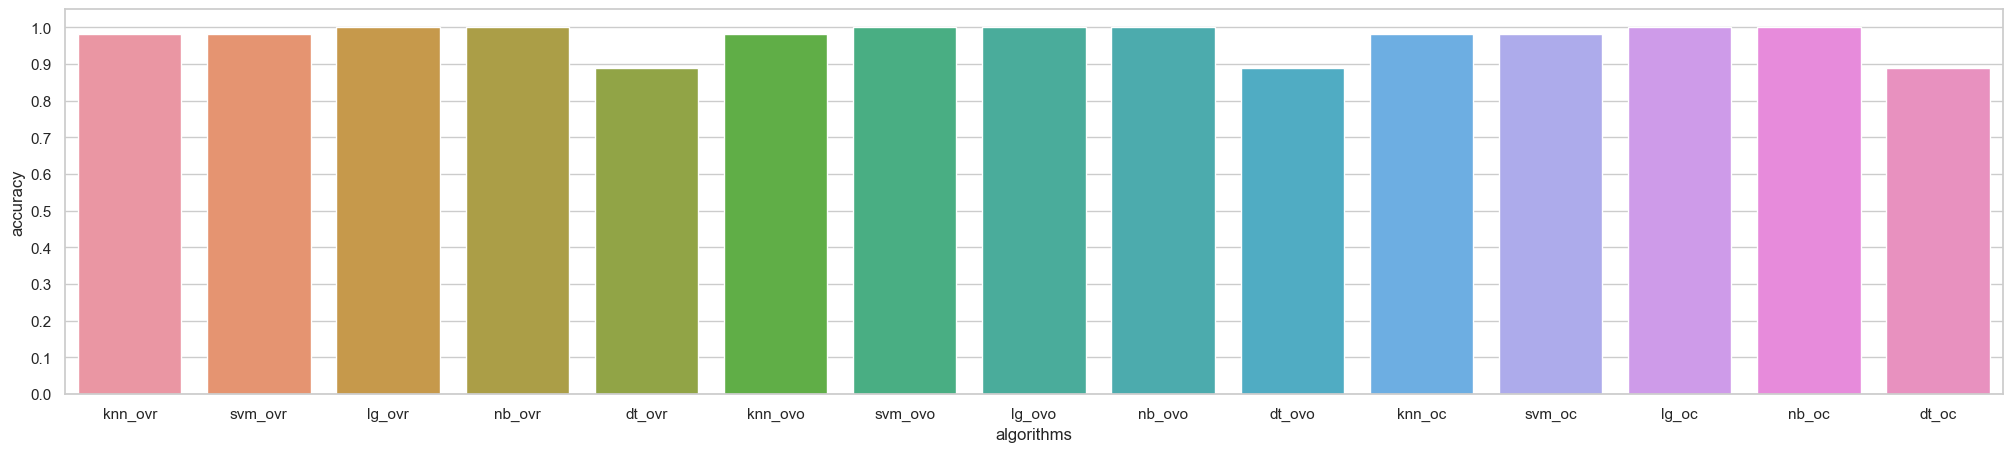

In [38]:
sns.set_style("whitegrid")
plt.figure(figsize=(25, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("accuracy")
plt.xlabel("algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))

#### Время

<AxesSubplot: xlabel='algorithms', ylabel='time'>

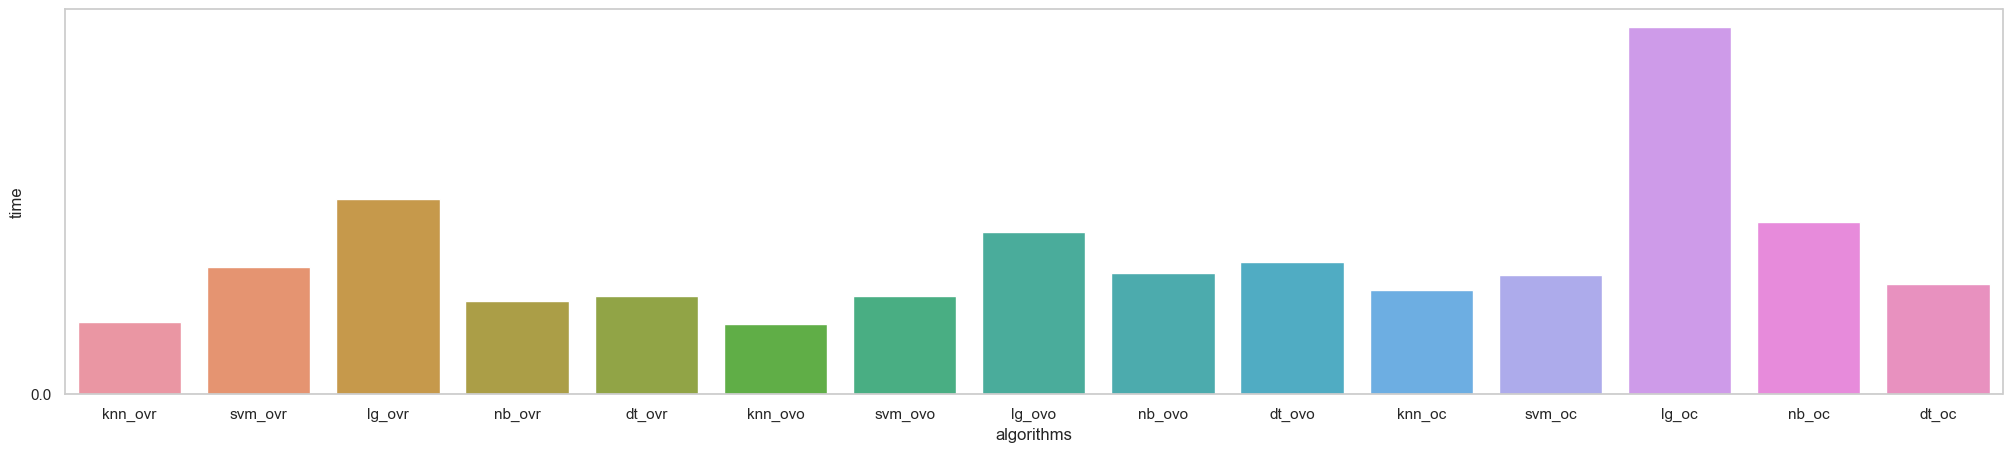

In [39]:
sns.set_style("whitegrid")
plt.figure(figsize=(25, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("time")
plt.xlabel("algorithms")
sns.barplot(x=list(times.keys()), y=list(times.values()))

In [71]:
df2 = pd.read_csv("Chicago_Crime_Final_Data.csv")

In [72]:
df2.columns = ['crime_type', 'location_desc', 'police_area', 'city_district', 'date', 'hour',
       'police_dist', 'precipitation', 'snowfall', 'snow_depth', 'temp_max', 'temp_min', 'wind_dir', 'wind_speed',
       'fog', 'fog_heavy', 'thunder', 'ice_pellet', 'glaze_rime', 'smoke_haze', 'snow_drift', 'day_week',
       'month', 'holiday']


frequent_crimes = ['BATTERY','THEFT','CRIMINAL DAMAGE']
df2 = df2[df2['crime_type'].isin(frequent_crimes)]


df2 = df2.sample(n=1000)


In [73]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
crime_types = le.fit_transform(df2["crime_type"])
df2["crime_type_cat"] = crime_types

locations = le.fit_transform(df2["location_desc"])
df2["location_desc_cat"] = locations

In [74]:
df2 = df2.drop(columns=["crime_type", "location_desc", "date", "fog", "fog_heavy", "thunder", "ice_pellet", "glaze_rime", "smoke_haze", "snow_drift", "holiday"])

In [75]:
X, y = df2.drop(columns=["crime_type_cat", "location_desc_cat"]), df2[["crime_type_cat", "location_desc_cat"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain

n_estimators_grid = [5, 50, 200]
max_depth_rf_grid = [None, 10, 20]
min_samples_split_rf_grid = [2, 5, 10]
params_rf = [{"n_estimators": n_estimators_grid,
              "max_depth": max_depth_rf_grid,
              "min_samples_split": min_samples_split_rf_grid}]

searcher_rf = GridSearchCV(RandomForestClassifier(random_state=123), params_rf, n_jobs=2, cv=10)
searcher_rf.fit(X_train_scaled, y_train)


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=123),
             n_jobs=2,
             param_grid=[{'max_depth': [None, 10, 20],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [5, 50, 200]}])

In [77]:
optimal_n_estimators = searcher_rf.best_params_["n_estimators"]
print(f"n_estimators: {optimal_n_estimators}")
optimal_max_depth = searcher_rf.best_params_["max_depth"]
print(f"max_depth: {optimal_max_depth}")
optimal_min_samples_split = searcher_rf.best_params_["min_samples_split"]
print(f"min_samples_split: {optimal_min_samples_split}")

n_estimators: 5
max_depth: None
min_samples_split: 2


In [78]:
accuracies2 = {}
times2 = {}

In [79]:
rf = RandomForestClassifier(random_state=123, n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, min_samples_split=optimal_min_samples_split)

MultiOutputClassifier

In [56]:
rf_moc = MultiOutputClassifier(rf).fit(X_train_scaled, y_train)
y_rf_moc = rf_moc.predict(X_test_scaled)

In [61]:
accuracies2["rf_moc"] = rf_moc.score(X_test_scaled, y_test)
times2["rf_moc"] = time_model(rf_moc, X_train_scaled, y_train)

ClassifierChain

In [80]:
rf_cc = ClassifierChain(rf).fit(X_train_scaled, y_train)
y_rf_cc = rf_cc.predict(X_test_scaled)

In [ ]:
accuracies2["rf_cc"] = rf_cc.score(X_test_scaled, y_test)
# times2["rf_cc"] = time_model(rf_cc, X_train_scaled, y_train)